22BAI1173\
04/03/2025\
Lab 8\
L39+L40\
chatgpt: https://chatgpt.com/share/67c6e467-366c-8004-ad4d-015d385a3749

# Question 1 - Implement adaptive thinning for handwritten character recognition.
  • Apply iterative thinning to reduce characters to a single-pixel width skeleton.\
  • Preserve stroke connectivity and prevent excessive erosion.\
  • Test on a dataset of handwritten characters (e.g., digits 0-9).\
  • Compare recognition accuracy before and after thinning.

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from skimage.morphology import thin

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

x_train = np.stack([x_train]*3, axis=-1)
x_test = np.stack([x_test]*3, axis=-1)

x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

<ipython-input-3-efa303044dea>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


In [4]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [5]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.5462 - loss: 1.4099 - val_accuracy: 0.6775 - val_loss: 0.9528
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6852 - loss: 0.9332 - val_accuracy: 0.6907 - val_loss: 0.8988
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6981 - loss: 0.8878 - val_accuracy: 0.7020 - val_loss: 0.8679
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7086 - loss: 0.8580 - val_accuracy: 0.7074 - val_loss: 0.8458
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7176 - loss: 0.8270 - val_accuracy: 0.7124 - val_loss: 0.8293


In [8]:
original_acc = model.evaluate(x_test, y_test, verbose=0)[1]
print(f"Recognition Accuracy on Original MNIST: {original_acc:.4f}")

Recognition Accuracy on Original MNIST: 0.7124


In [9]:
def thinning_with_skimage(image):
    if len(image.shape) == 3 and image.shape[2] > 1:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    _, binary_image = cv2.threshold(image, 0.5, 1, cv2.THRESH_BINARY)

    thinned_image = thin(binary_image)

    return thinned_image.astype(np.float32)

In [10]:
x_test_thinned = np.array([thinning_with_skimage(img.squeeze()) for img in x_test.numpy()])
x_test_thinned = np.stack([x_test_thinned]*3, axis=-1)
x_test_thinned = tf.image.resize(x_test_thinned, (32, 32))

In [11]:
thinned_acc = model.evaluate(x_test_thinned, y_test, verbose=0)[1]
print(f"Recognition Accuracy on Thinned MNIST: {thinned_acc:.4f}")

Recognition Accuracy on Thinned MNIST: 0.2914


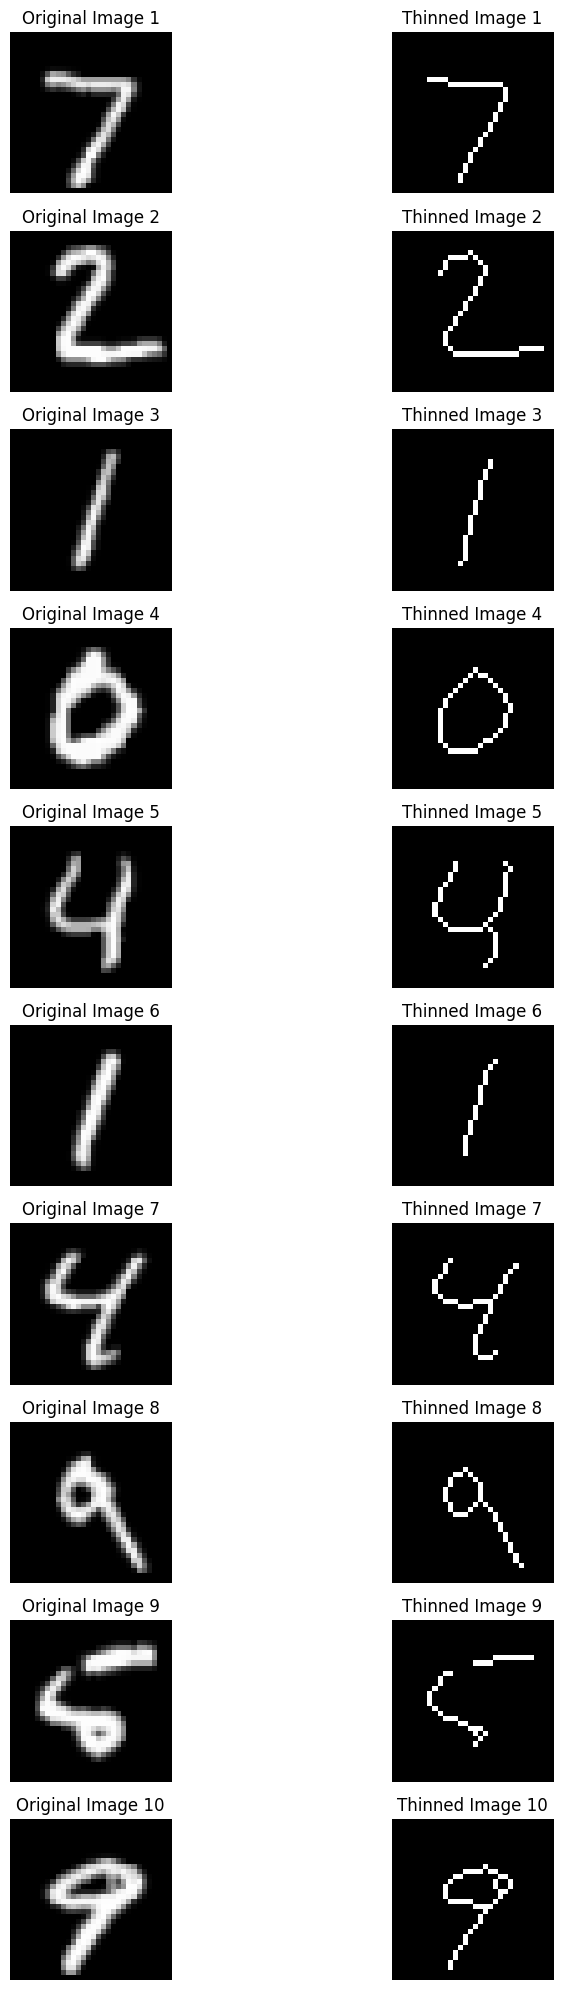

In [12]:
fig, axes = plt.subplots(10, 2, figsize=(10, 10 * 2))

for i in range(10):
    axes[i, 0].imshow(x_test[i].numpy().squeeze(), cmap='gray')
    axes[i, 0].set_title(f'Original Image {i + 1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(x_test_thinned[i].numpy().squeeze(), cmap='gray')
    axes[i, 1].set_title(f'Thinned Image {i + 1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Question 2 - Implement region filling to restore missing tissues in medical scans.
  • Select medical images (e.g., MRI, CT) with missing regions due to artifacts.\
  • Implement morphological region filling to reconstruct missing tissue.\
  • Compare with PDE-based inpainting and interpolation techniques.\
  • Evaluate the restoration accuracy using similarity metrics (SSIM, PSNR).

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import inpaint
from scipy.interpolate import griddata

In [16]:
def load_medical_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    return img

In [26]:
def create_mask(image, missing_percentage=0.1):
    mask = np.zeros_like(image, dtype=np.uint8)
    h, w = image.shape
    num_pixels = int(h * w * missing_percentage)

    coords = np.random.randint(0, h, (num_pixels, 2))
    for x, y in coords:
        mask[x-2:x+2, y-2:y+2] = 255

    corrupted_image = image.copy()
    corrupted_image[mask == 255] = 0
    return corrupted_image, mask

In [27]:
image_path = "image.png"
original = load_medical_image(image_path)
corrupted, mask = create_mask(original)

In [20]:
def morphological_filling(image, mask):
    filled = image.copy()
    kernel = np.ones((3, 3), np.uint8)

    # Iteratively dilate the missing regions
    while np.any(mask):
        dilation = cv2.dilate(filled, kernel, iterations=1)
        filled[mask == 255] = dilation[mask == 255]  # Fill missing areas
        mask = cv2.erode(mask, kernel, iterations=1)  # Reduce mask

    return filled

In [19]:
def pde_inpainting(image, mask):
    return cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

In [21]:
def interpolation_filling(image, mask):
    h, w = image.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))

    known_pixels = mask == 0
    missing_pixels = mask == 255

    # Extract known pixel values and their coordinates
    known_x, known_y = x[known_pixels], y[known_pixels]
    known_values = image[known_pixels]

    # Interpolate missing values
    interpolated_values = griddata((known_x, known_y), known_values, (x, y), method='cubic')

    # Fill the missing areas
    restored = image.copy()
    restored[missing_pixels] = np.nan_to_num(interpolated_values[missing_pixels])
    return restored

In [28]:
morph_filled = morphological_filling(corrupted, mask)
pde_filled = pde_inpainting(corrupted, mask)
interp_filled = interpolation_filling(corrupted, mask)

In [22]:
def compute_metrics(original, restored):
    ssim_value = ssim(original, restored, data_range=original.max() - original.min())
    psnr_value = cv2.PSNR(original, restored)
    return ssim_value, psnr_value

In [29]:
methods = {"Morphological": morph_filled, "PDE": pde_filled, "Interpolation": interp_filled}
for method, restored in methods.items():
    ssim_value, psnr_value = compute_metrics(original, restored)
    print(f"{method} Filling -> SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f} dB")

Morphological Filling -> SSIM: 0.7488, PSNR: 24.12 dB
PDE Filling -> SSIM: 0.7625, PSNR: 25.83 dB
Interpolation Filling -> SSIM: 0.7177, PSNR: 16.68 dB


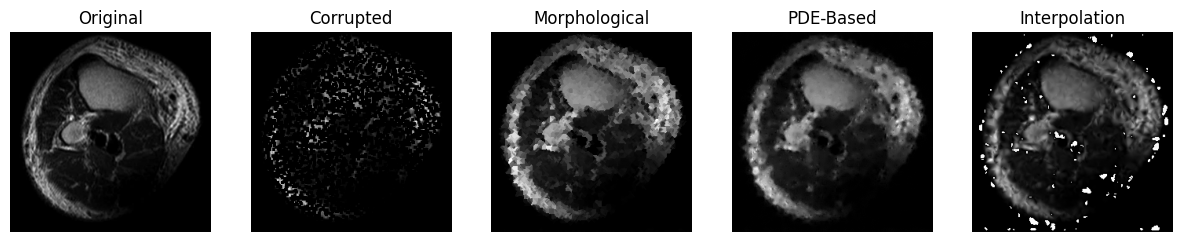

In [30]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(original, cmap='gray'); axes[0].set_title("Original")
axes[1].imshow(corrupted, cmap='gray'); axes[1].set_title("Corrupted")
axes[2].imshow(morph_filled, cmap='gray'); axes[2].set_title("Morphological")
axes[3].imshow(pde_filled, cmap='gray'); axes[3].set_title("PDE-Based")
axes[4].imshow(interp_filled, cmap='gray'); axes[4].set_title("Interpolation")
for ax in axes: ax.axis("off")
plt.show()

# Question 3 - Implement skeletonization to analyze leaf vein structures for plant species classification.
  • Acquire high-resolution leaf images.\
  • Apply skeletonization to extract vein structures.\
  • Analyze vein topology (length, branching points) for classification.\
  • Compare with contour-based leaf analysis methods.

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops

In [32]:
def load_leaf_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512, 512))  # Resize for consistency
    return img

In [33]:
def preprocess_image(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)

    _, binary = cv2.threshold(enhanced, 128, 255, cv2.THRESH_BINARY_INV)
    return binary

In [34]:
def extract_skeleton(binary_image):
    skeleton = skeletonize(binary_image // 255)
    return (skeleton * 255).astype(np.uint8)

In [35]:
image_path = "leaf.jpg"
leaf_image = load_leaf_image(image_path)
binary_leaf = preprocess_image(leaf_image)
skeleton = extract_skeleton(binary_leaf)

In [36]:
def analyze_vein_topology(skeleton):
    labeled_skeleton = label(skeleton)
    regions = regionprops(labeled_skeleton)

    total_length = sum(region.perimeter for region in regions)
    branching_points = sum(1 for region in regions if region.eccentricity < 0.8)  # Approx. branch points

    return total_length, branching_points

In [37]:
def contour_analysis(binary_image):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_lengths = [cv2.arcLength(cnt, closed=False) for cnt in contours]
    return sum(contour_lengths)

In [38]:
vein_length, branching_pts = analyze_vein_topology(skeleton)
contour_length = contour_analysis(binary_leaf)

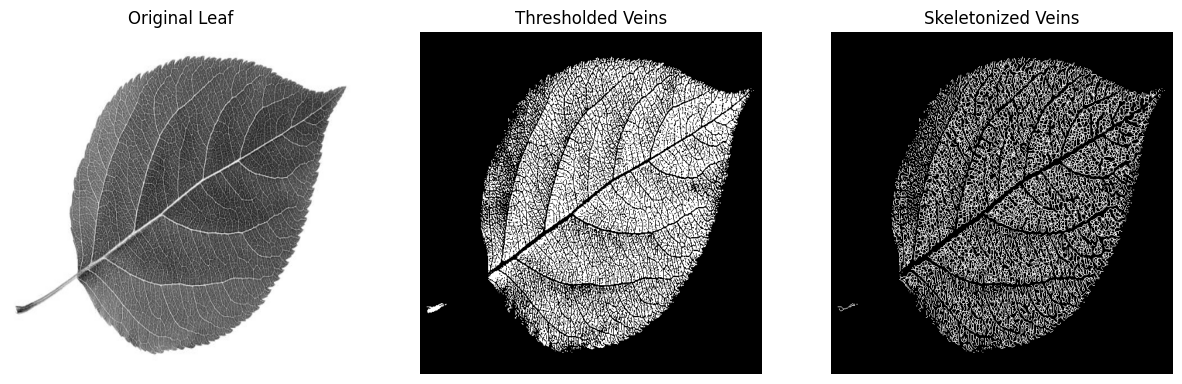

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(leaf_image, cmap='gray'); axes[0].set_title("Original Leaf")
axes[1].imshow(binary_leaf, cmap='gray'); axes[1].set_title("Thresholded Veins")
axes[2].imshow(skeleton, cmap='gray'); axes[2].set_title("Skeletonized Veins")
for ax in axes: ax.axis("off")
plt.show()

In [40]:
print(f"Skeletonized Vein Length: {vein_length:.2f}")
print(f"Branching Points: {branching_pts}")
print(f"Contour-Based Vein Length: {contour_length:.2f}")

Skeletonized Vein Length: 39828.95
Branching Points: 196
Contour-Based Vein Length: 74254.43
